In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind

import cobra
from cobra.io import read_sbml_model, load_json_model, load_yaml_model, load_matlab_model, load_model

/miniconda3/envs/rbcenv/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Get ids of central carbon metabolism from GSM

In [69]:
# Load P putida model iJN1563
model = load_model('iJN1463')
# Read proteins ids of Central Carbon Metabolism
ids = pd.read_excel('../data/proteins_id.xlsx')
# Ensembl Gene ID to Gene Symbol
id_convervtion = pd.read_excel('../data/gs_to_geneid.xlsx')

In [70]:
# Get Gene reaction rule from GSM for proteins of interests
genes_ids = [] 
for i in range(0,ids.shape[0]):
    genes_ids.append(model.reactions.get_by_id(ids.iloc[i,0]).gene_reaction_rule)
genes_ids

#Parsing gene ids
ids['genes'] = [i.replace(' and ', ',').replace(' or ', ',') for i in genes_ids]
ids.to_excel('../data/ccm_ids.xlsx')
list_of_strings = [i.replace(' and ', ',').replace(' or ', ',') for i in genes_ids]
list_of_lists = [i.split(",") for i in list_of_strings]
list_of_ids = [item for sublist in list_of_lists for item in sublist]

list_of_ids = list_of_ids  + ['PP_0339','PP_0338','PP_4187','PP_0339','PP_0338','PP_5366' ] # add PDH which did not parsed correctly

## Read proteomics data

In [22]:
proteomics_file_name = '../data/Proteomics.xlsx'
proteomics = pd.read_excel(proteomics_file_name)
proteomics.set_index('Ensembl Gene ID', inplace=True) # Ensembl Gene ID
meta = pd.read_excel('../data/meta_proteomics.xlsx')

In [25]:
# drop proteins which have more than 15 NAs and fill the rest of NAs with 0
proteomics = proteomics.dropna(thresh=15, axis=0)
proteomics = proteomics.fillna(0)

In [24]:
# Proteomics with gene symbols 
proteomics_gs = pd.read_excel('../data/Proteomics_gs.xlsx')
proteomics_gs.set_index('Gene Symbol', inplace=True)
proteomics_gs = proteomics_gs.dropna(thresh=15, axis=0)
proteomics_gs = proteomics_gs.fillna(0)

## t-test analysis of proteomics

In [26]:
def fdr(p_vals):

    from scipy.stats import rankdata
    ranked_p_values = rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1

    return fdr

def do_ttest(group1,group2):
    g1_boolen = meta['Strain'].isin([group1]).values
    g2_boolen = meta['Strain'].isin([group2]).values
    g1 = proteomics.loc[:,g1_boolen]
    g2 = proteomics.loc[:,g2_boolen]
    g1_mean = g1.transpose().mean()
    g2_mean = g2.transpose().mean()
    fc = g1_mean/(g2_mean+1e-9)
    lfc = np.log(fc)
    ttest = ttest_ind(g1.transpose(), 
          g2.transpose(), 
          equal_var=False, # it's not necessarily fair to assume that these two populations have equal variance
          nan_policy='omit')
    return ttest,lfc

def analyze_ttest(group1,group2):
    ttest, lfc = do_ttest(group1,group2)
    calculated = np.transpose(np.array([fdr(ttest.pvalue),ttest.pvalue,lfc]))
    df = pd.DataFrame(calculated,columns=['p-value corrected', 'p-value', 'logFC'])
    df['significant'] = df['p-value corrected']<0.01
    df['-log10 p-value'] = -np.log10(df['p-value corrected'])
    df['direction'] = np.where(df['logFC']>0, 'up', 'down')
    df['more than 1.5 FC'] = np.where(df['logFC'].abs() > 1.5, True, False)
    df.index = proteomics.index
    df['gene symbol'] = proteomics_gs.index
    more_than_2p5_fc = df[df['more than 1.5 FC']==True]
    return df,more_than_2p5_fc

def do_volcano(df,group1,group2,plotname):
    sns.scatterplot(data=df, y = '-log10 p-value', x = 'logFC', color=['grey'] ).set(xlim=(-11, 11))
    sns.scatterplot(data=df[df['significant']==True], y = '-log10 p-value', x = 'logFC',hue = 'direction',
                    palette = ['navy','crimson'] ).set(xlim=(-11, 11))
    plt.title(f"{group1} vs. {group2}")
    plt.savefig(plotname, transparent=True)

### PHB vs WT

/miniconda3/envs/rbcenv/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


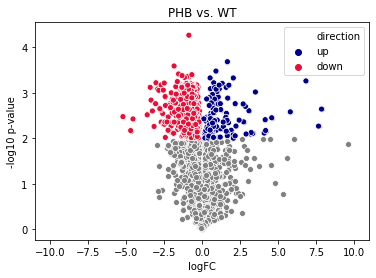

In [60]:
group1 = 'PHB'
group2 = 'WT'
plotname = '../figures/proteomics_ttest_results/' + group1 + 'vs' + group2 + '.svg'
df,more_than_2p5_fc = analyze_ttest(group1,group2)
do_volcano(df,group1,group2,plotname)
ccm = df.loc[[l for l in list_of_ids if l in df.index.values]]
np.sum(df.significant.values)
dfname =  '../figures/proteomics_ttest_results/' + group1 + 'vs' + group2 +'.xlsx'
df.to_excel(dfname)

In [61]:
n = more_than_2p5_fc[more_than_2p5_fc['significant']==True].shape[0]
f"Number of proteins with signicantly changed abundance level and more than 2.5 logFC: {n}"

'Number of proteins with signicantly changed abundance level and more than 2.5 logFC: 112'

### PHB vs gltA

/miniconda3/envs/rbcenv/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


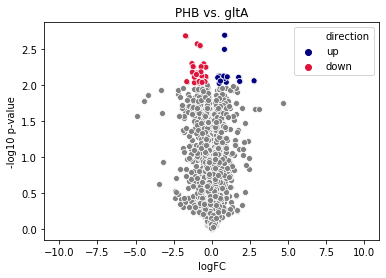

In [62]:
group1 = 'PHB'
group2 = 'gltA'
plotname = '../figures/proteomics_ttest_results/' + group1 + 'vs' + group2 + '.svg'
df,more_than_2p5_fc = analyze_ttest(group1,group2,)
do_volcano(df,group1,group2,plotname)
ccm = df.loc[[l for l in list_of_ids if l in df.index.values]]
np.sum(df.significant.values)
dfname = '../figures/proteomics_ttest_results/' + group1 + 'vs' + group2 +'.xlsx'
df.to_excel(dfname)

In [63]:
n = more_than_2p5_fc[more_than_2p5_fc['significant']==True].shape[0]
f"Number of proteins with signicantly changed abundance level and more than 2.5 logFC: {n}"

'Number of proteins with signicantly changed abundance level and more than 2.5 logFC: 5'

### PHB versus accA

/miniconda3/envs/rbcenv/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


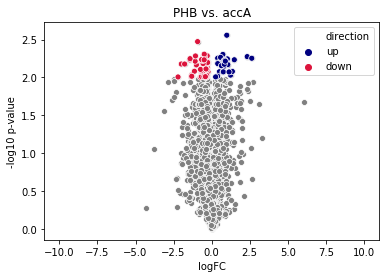

In [64]:
group1 = 'PHB'
group2 = 'accA'
plotname = '../figures/proteomics_ttest_results/' + group1 + 'vs' + group2 + '.svg'
df,more_than_2p5_fc = analyze_ttest(group1,group2)
do_volcano(df,group1,group2,plotname)
ccm = df.loc[[l for l in list_of_ids if l in df.index.values]]
np.sum(df.significant.values)
dfname = '../figures/proteomics_ttest_results/' + group1 + 'vs' + group2 +'.xlsx'
df.to_excel(dfname)

In [65]:
n = more_than_2p5_fc[more_than_2p5_fc['significant']==True].shape[0]
f"Number of proteins with signicantly changed abundance level and more than 2.5 logFC: {n}"

'Number of proteins with signicantly changed abundance level and more than 2.5 logFC: 5'

### PHB vs gltAaccA

/miniconda3/envs/rbcenv/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


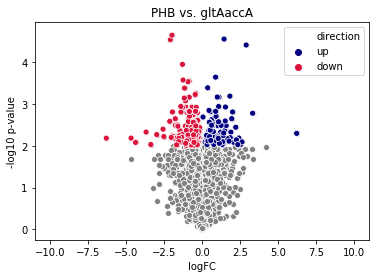

In [66]:
group1 = 'PHB'
group2 = 'gltAaccA'
plotname = '../figures/proteomics_ttest_results/' + group1 + 'vs' + group2 + '.svg'
df,more_than_2p5_fc = analyze_ttest(group1,group2)
do_volcano(df,group1,group2,plotname)
ccm = df.loc[[l for l in list_of_ids if l in df.index.values]]
np.sum(df.significant.values)
dfname = '../figures/proteomics_ttest_results/' + group1 + 'vs' + group2 + '.xlsx'
df.to_excel(dfname)

In [67]:
n = more_than_2p5_fc[more_than_2p5_fc['significant']==True].shape[0]
f"Number of proteins with signicantly changed abundance level and more than 2.5 logFC: {n}"

'Number of proteins with signicantly changed abundance level and more than 2.5 logFC: 50'

### PHB versus ftsZ

/miniconda3/envs/rbcenv/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


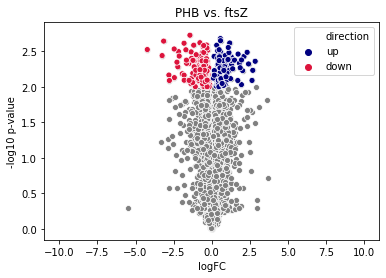

In [59]:
group1 = 'PHB'
group2 = 'ftsZ'
plotname = group1+'vs'+group2+'.svg'
df,more_than_2p5_fc = analyze_ttest(group1,group2)
do_volcano(df,group1,group2,plotname)
ccm = df.loc[[l for l in list_of_ids if l in df.index.values]]
np.sum(df.significant.values)
dfname = '../figures/proteomics_ttest_results/' + group1 + 'vs' + group2 + '.xlsx'
df.to_excel(dfname)


In [40]:
n = more_than_2p5_fc[more_than_2p5_fc['significant']==True].shape[0]
f"Number of proteins with signicantly changed abundance level and more than 2.5 logFC: {n}"

'Number of proteins with signicantly changed abundance level and more than 2.5 logFC: 35'

In [71]:
# Subset of proteimics of only central carbom metabolism proteins
ccm_proteomics = proteomics.loc[[l for l in ccm.index.values if l in proteomics.index.values]]

In [72]:
# list of gene ids not found in proteomics
[l for l in list_of_ids if l not in proteomics.index.values]

['PP_1016',
 'PP_1017',
 'PP_3417',
 'PP_0652',
 'PP_3377',
 'PP_4301',
 'PP_1445',
 '( PP_0339',
 'PP_4187 )',
 '( PP_0339',
 'PP_5366 )',
 'PP_4379']

In [73]:
# take away WT and ftsZ1
ids = [0,1,2,6,7,8,9,10,11,12,13,14]
strain = ['PHB','PHB','PHB','gltA','gltA','gltA','accA','accA','accA','gltAaccA','gltAaccA','gltAaccA']
strain_short = ['PHB','gltA','accA','gltAaccA']

In [74]:
# Get median value for each strain and each protein. Normalize to PHB
t_df = ccm_proteomics.copy().transpose()
t_df["Strain"] = meta["Strain"].values
t_df.head()
median_df = t_df.groupby(["Strain"]).median()
median_df_norm = median_df/median_df.loc['PHB']
median_df_norm

Ensembl Gene ID,PP_1015,PP_1018,PP_1011,PP_3416,PP_3378,PP_3376,PP_1444,PP_3382,PP_3383,PP_3384,...,PP_1915,PP_1913,PP_0356,PP_4116,PP_0339,PP_0338,PP_4187,PP_0339,PP_0338,PP_5366
Strain,,,,,,,,,,,,,,,,,,,,,
PHB,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
WT,0.700273,1.074124,0.674101,0.665053,1.654718,1.906735,1.020746,4.551519,1.771823,1.946819,...,1.185728,1.114162,1.349615,4.130824,1.643502,1.303332,1.862737,1.643502,1.303332,1.449793
accA,0.897489,1.338354,0.964011,1.129226,3.023827,3.912039,1.030873,3.918362,3.339386,2.451763,...,1.207781,0.793159,1.486832,1.759242,1.872842,1.148200,1.095918,1.872842,1.148200,1.495735
ftsZ,0.397944,1.072216,1.114448,1.175857,9.003474,7.158588,0.847506,13.168864,3.008095,3.141698,...,0.819148,0.786288,1.034853,0.974183,2.792800,1.693421,1.372584,2.792800,1.693421,1.166156
gltA,0.463515,0.848957,0.914902,0.784745,1.363499,4.031294,0.635674,7.357859,2.300262,2.558975,...,0.939761,0.615982,1.172877,2.136380,2.076695,1.414369,1.682217,2.076695,1.414369,1.538031
gltAaccA,0.485037,1.193438,0.906338,0.915021,4.561384,7.067411,1.155164,11.148108,3.652707,3.565478,...,1.153306,1.535435,1.523062,2.633105,2.192230,1.444523,1.729450,2.192230,1.444523,1.715430


In [75]:
# Create a norm for matplotlib in order to have same colormap for every plot
mini = median_df_norm.drop(['PHB','WT','ftsZ']).min().min()
maxi = median_df_norm.drop(['PHB','WT','ftsZ']).max().max()
norm = plt.Normalize(mini, maxi)

Text(0.5, 1, 'glcB')

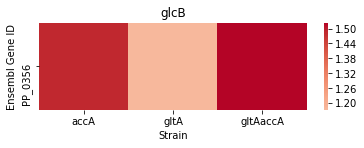

In [76]:
# The plot will look like that
gene = 'PP_0356'
fig, ax = plt.subplots(figsize=(6,1.6)) 
sns.heatmap(data = median_df_norm[[gene]].drop(['PHB','WT','ftsZ']).transpose(), center=1, cmap='coolwarm', ax=ax, norm = norm)
plt.title(f"{ccm.loc[gene]['gene symbol']}")

In [47]:
# Generate png plots
for gene in median_df_norm.columns.values:
    plot_name = '../figures/mini_heatmaps_proteomics/' + 'hm_'+gene+'.png'
    fig, ax = plt.subplots()
    data_ = median_df_norm[[gene]].iloc[:,[0]].drop(['PHB','WT','ftsZ']).transpose().values
    ax.imshow(data_, cmap='coolwarm', norm = norm)
    plt.title(f"{ccm.loc[gene]['gene symbol']}")
    plt.savefig(plot_name, transparent=True)
    plt.close()

In [48]:
# Generate svg plots
for gene in median_df_norm.columns.values:
    plot_name = '../figures/mini_heatmaps_proteomics/' + 'hm_'+gene+'.svg'
    fig, ax = plt.subplots(figsize=(1.1,1.1))
    data_ = median_df_norm[[gene]].iloc[:,[0]].drop(['PHB','WT','ftsZ']).transpose().values
    ax.imshow(data_, cmap='coolwarm', norm = norm)
    ax.axis('off')
    plt.savefig(plot_name, transparent=True)
    plt.close()

In [65]:
id_conv = pd.read_excel('gs_to_geneid.xlsx')
id_conv.index = id_conv['Ensembl Gene ID']
median_df_norm.columns
id_conv.loc[median_df_norm.columns]['Gene Symbol'].values

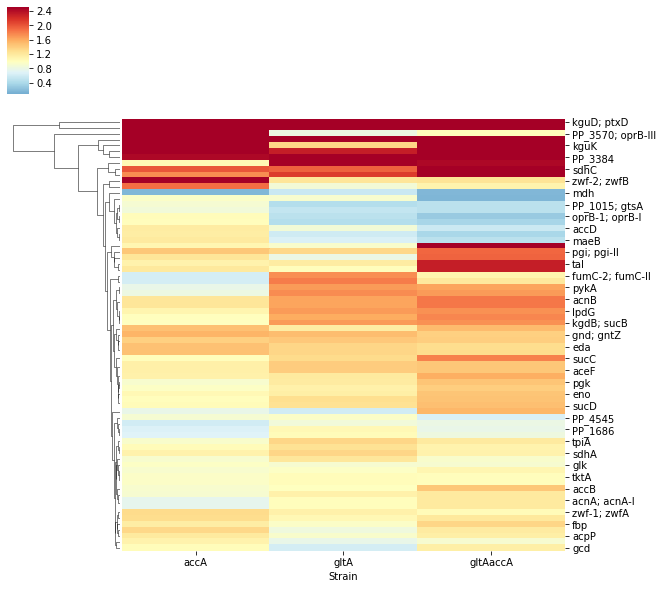

In [69]:
# All central carbon metabolism proteins heatmap
ccm_mediam_norm = median_df_norm.copy()
ccm_mediam_norm.columns = id_conv.loc[median_df_norm.columns]['Gene Symbol'].values
sns.clustermap(data = ccm_mediam_norm.drop(['PHB','WT','ftsZ']).transpose(), center=1, cmap='RdYlBu_r',vmin=0.1,vmax=2.5, norm = norm,col_cluster=False)
plt.title(f"")
plt.savefig('one_heatmap')

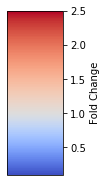

In [260]:
# Generate legend for mini heatmaps
import matplotlib as mpl
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(1, 6))
fig.subplots_adjust(bottom=0.5)

#norm_ = plt.Normalize(mini, maxi)
norm_ = mcolors.DivergingNorm(vmin= 0.1, vcenter = 1.0 , vmax = 2.5)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm_, cmap='coolwarm'),
             cax=ax, orientation='vertical', label='Fold Change')

plt.savefig('legend.svg')